# Análisis de votaciones en el Congreso de Perú
Objetivo: limpiar los datos, calcular métricas de cohesión por bancada/grupo, explorar patrones de co-voto, visualizar agrupamientos y probar si los patrones de voto permiten predecir la bancada.

In [24]:
# Celdas de configuración e imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook", palette="muted")

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

import networkx as nx  # opcional para grafo de co-voto

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [25]:
# Cargar metadatos de congresistas
congress = pd.read_csv("Congreso.csv", index_col=0)

# Normalizaciones/limpieza (basadas en tu notebook original)
congress.loc[congress["Grupo"] == "Partido Democrático Somos Perú", "Grupo"] = "Somos Perú"
congress.loc[congress["Grupo"] == "Alianza para el Progreso del Perú", "Grupo"] = "Alianza para el Progreso"
congress.loc[congress["Bancada"] == "ACCION POPULAR", "Bancada"] = "ACCIÓN POPULAR"

# Revisar
congress.head()

,Congresista,Región,Bancada,Grupo,Votacion
0,Acuña Peralta María Grimaneza,Lambayeque,ALIANZA PARA EL PROGRESO,Alianza para el Progreso,"11,384"
1,Acuña Peralta Segundo Héctor,La libertad,HONOR Y DEMOCRACIA,Alianza para el Progreso,"19,729"
2,Agüero Gutiérrez María Antonieta,Arequipa,PERÚ LIBRE,Partido Politico Nacional Perú Libre,"29,293"
3,Aguinaga Recuenco Alejandro Aurelio,Lambayeque,FUERZA POPULAR,Fuerza Popular,"10,715"
4,Alcarraz Aguero Yorel Kira,LIMA,PODEMOS PERÚ,Somos Perú,"28,404"


In [26]:
# Lista de carpetas/archivos que ya usabas
file_names = ["1.4.1", "1.2.3", "1.4.2", "1.3.2", "1.3.1", "1.2.2", "1.2.1", "1.1.1"]

# Leer y sustituir 2 por NA (ausencia/NO INFO) y concatenar columnas
dfs = []
for fname in file_names:
    df = pd.read_csv(fname + ".csv", index_col=0)
    # si prefieres identificar de dónde viene cada columna:
    # df = df.add_prefix(fname + " | ")
    df = df.where(df < 2)   # 2 -> NaN (equivalente a replace(2, np.nan))
    # for integer NA dtype (optional): df = df.astype('Int64')
    dfs.append(df)

votes = pd.concat(dfs, axis=1)

# Verifica duplicados en nombres de columnas
dups = votes.columns[votes.columns.duplicated()].unique()
if len(dups) > 0:
    print("Columnas duplicadas detectadas:", dups)
    
votes.shape, votes.head()

Columnas duplicadas detectadas: Index(['VOTACIÓN DEL PROYECTO DE  RESOLUCIÓN LEGISLATIVA DEL',
       'LA VOTACIÓN DEL PROYECTO DE  RESOLUCIÓN LEGISLATIVA DEL',
       'VOTACIÓN DEL TEXTO SUSTITUTORIO  DEL PROYECTO 10 Y OTROS',
       'VOTACIÓN DE LA RECONSIDERACIÓN DE  LA VOTACIÓN DEL PROYECTO DE RESOLUCIÓN LEGISLATIVA  DEL',
       'VOTACIÓN DE LA CUESTIÓN PREVIA  PARA QUE RETORNE A LA COMISIÓN DE CONSTITUCIÓN   EL PROYECTO 1964'],
      dtype='object')


((138, 2790),
    VOTACIÓN DEL PROYECTO 1271  \
 0                         1.0   
 1                         NaN   
 2                         1.0   
 3                         0.0   
 4                         NaN   
 
    VOTACIÓN DEL NUEVO TEXTO     SUSTITUTORIO DE LOS PROYECTOS 327 Y 905  \
 0                                                1.0                      
 1                                                1.0                      
 2                                                1.0                      
 3                                                1.0                      
 4                                                1.0                      
 
    VOTACIÓN DE L A EXONERACIÓN DE   SEGUNDA VOTACIÓN DE LOS PROYECTOS 327 Y 905  \
 0                                                1.0                              
 1                                                1.0                              
 2                                                1.0                 

In [27]:
# Confirmar que el índice de votes coincide con el de congress (IDs)
print("Índice congr:", congress.index.min(), "-", congress.index.max())
print("Índice votes:", votes.index.min(), "-", votes.index.max())
# Si todo OK, votes.index son los IDs y coinciden con el index de congress
# A partir de aquí: rows = congresistas (index), columns = votaciones

# Asegurarse de que el index sea entero y ordenado
votes.index = votes.index.astype(int)
votes = votes.sort_index()
congress = congress.sort_index()

Índice congr: 0 - 137
Índice votes: 0 - 137


Notas:
- Codificación: 1 = A favor, -1 = En contra, 0 = Abstención, NaN = ausente / no extraído.

In [28]:
# Resumen global: conteo por valor en todo el dataset
all_values = votes.stack(dropna=False).astype(object)
print("Frecuencias globales de votos:")
print(all_values.value_counts(dropna=False))

# Por congresista: conteo de tipos de voto
summary_by_congressman = pd.DataFrame({
    "A_favor": (votes == 1).sum(axis=1),
    "En_contra": (votes == -1).sum(axis=1),
    "Abstencion": (votes == 0).sum(axis=1),
    "Ausente": votes.isna().sum(axis=1),
    "Total_votaciones": votes.notna().sum(axis=1)
})
display(summary_by_congressman.sort_values("Ausente", ascending=False).head(10))

# Por votación (columna): mostrar primeras columnas
summary_by_vote = pd.DataFrame({
    "A_favor": (votes == 1).sum(axis=0),
    "En_contra": (votes == -1).sum(axis=0),
    "Abstencion": (votes == 0).sum(axis=0),
    "N_presentes": votes.notna().sum(axis=0)
})
display(summary_by_vote.head(8))

Frecuencias globales de votos:
 1.0    232548
 NaN    103433
-1.0     39703
 0.0      9336
Name: count, dtype: int64


/tmp/ipykernel_4539/318362139.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  all_values = votes.stack(dropna=False).astype(object)


,A_favor,En_contra,Abstencion,Ausente,Total_votaciones
56,38,18,3,2731,59
136,163,11,0,2616,174
27,171,67,19,2533,257
88,243,28,5,2514,276
44,468,62,9,2251,539
115,533,76,15,2166,624
40,550,75,21,2144,646
110,700,123,22,1945,845
106,678,153,18,1941,849
131,957,117,19,1697,1093


,A_favor,En_contra,Abstencion,N_presentes
VOTACIÓN DEL PROYECTO 1271,33,44,27,104
VOTACIÓN DEL NUEVO TEXTO SUSTITUTORIO DE LOS PROYECTOS 327 Y 905,111,0,0,111
VOTACIÓN DE L A EXONERACIÓN DE SEGUNDA VOTACIÓN DE LOS PROYECTOS 327 Y 905,110,0,0,110
VOTACIÓN DEL TEXTO SUSTITUTORIO DEL PROYECTO 699,107,0,0,107
VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL PROYECTO 699,105,0,0,105
VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,114,0,0,114
VOTACIÓN DE LA EXONERACIÓN DE SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,110,3,0,113
VOTACIÓN DE LA RECONSIDERACIÓN A LA VOTACIÓN DEL TEXTO SUSTITUTORIO DE LOS PROYECTOS 668 Y 1073,44,49,17,110


/tmp/ipykernel_4539/4270174290.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  abs_by_group = votes_with_meta.groupby("Grupo").apply(lambda df: df.drop(columns=["Grupo","Bancada","Región"]).isna().mean().mean())


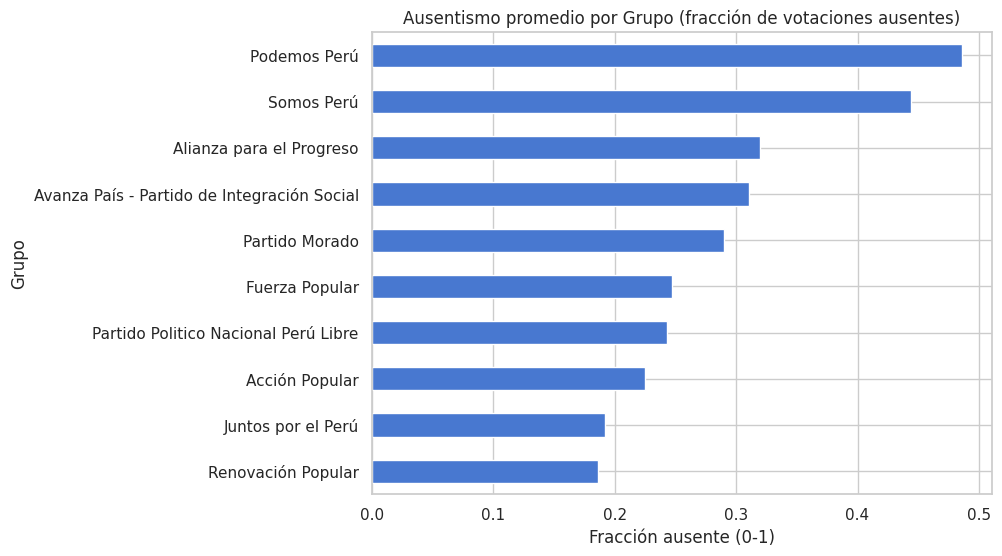

In [29]:
# Unir votes con metadata: añadir columnas del df de congreso
votes_with_meta = votes.join(congress[["Grupo", "Bancada", "Región"]])

# Ausentismo por grupo (promedio de ausencias)
abs_by_group = votes_with_meta.groupby("Grupo").apply(lambda df: df.drop(columns=["Grupo","Bancada","Región"]).isna().mean().mean())
abs_by_group = abs_by_group.sort_values()
abs_by_group.plot(kind="barh", figsize=(8,6), title="Ausentismo promedio por Grupo (fracción de votaciones ausentes)")
plt.xlabel("Fracción ausente (0-1)")
plt.show()

Calcularemos:
- Rice index (por votación y promedio por grupo): |SÍ - NO| / (SÍ + NO)
- Cohesión par-a-par (para cada grupo): para cada votación calculamos proporción de pares dentro del grupo que estuvieron de acuerdo, promediamos sobre las votaciones.

In [30]:
def rice_index_per_vote(series):
    """Rice index para una columna (serie de votos): |#1 - #(-1)| / (#1 + #(-1))"""
    s = series.dropna()
    yes = (s == 1).sum()
    no = (s == -1).sum()
    denom = yes + no
    return np.nan if denom == 0 else abs(yes - no) / denom

def avg_rice_by_group(votes_df, group_series):
    """Promedio del Rice index por grupo (media sobre votaciones)"""
    results = {}
    for g, members in group_series.groupby(group_series).groups.items():
        # members es un Index de IDs
        sub = votes_df.loc[members]
        rice_per_col = sub.apply(rice_index_per_vote, axis=0)
        results[g] = rice_per_col.mean(skipna=True)
    return pd.Series(results).sort_values(ascending=False)

def pairwise_cohesion_by_group(votes_df, group_series):
    """Cohesión por pares (para cada grupo) usando iloc para evitar problemas con columnas duplicadas."""
    results = {}
    groups = group_series.unique()
    for g in groups:
        members = group_series[group_series == g].index
        sub = votes_df.loc[members]
        col_scores = []
        for j in range(sub.shape[1]):
            colvals = sub.iloc[:, j].dropna()   # usar iloc evita seleccionar múltiples columnas por nombre duplicado
            n = len(colvals)
            if n < 2:
                continue
            counts = colvals.value_counts()
            # acuerdos = sum(comb(count,2) para cada valor)
            agreements = sum(v*(v-1)/2 for v in counts)
            total_pairs = n*(n-1)/2
            col_scores.append(agreements / total_pairs)
        results[g] = np.nanmean(col_scores) if len(col_scores) > 0 else np.nan
    return pd.Series(results).sort_values(ascending=False)

In [31]:
group_series = congress["Grupo"]

rice_scores = avg_rice_by_group(votes.drop(columns=["Grupo","Bancada","Región"], errors="ignore") if "Grupo" in votes.columns else votes, group_series)
cohesion_scores = pairwise_cohesion_by_group(votes.drop(columns=["Grupo","Bancada","Región"], errors="ignore") if "Grupo" in votes.columns else votes, group_series)

print("Rice index (promedio por grupo):")
display(rice_scores)

print("Cohesión par-a-par (promedio por grupo):")
display(cohesion_scores)

# Juntar en un DataFrame para una comparación rápida
cohesion_df = pd.DataFrame({
    "Rice": rice_scores,
    "Pairwise_cohesion": cohesion_scores
}).dropna().sort_values("Pairwise_cohesion", ascending=False)
display(cohesion_df)

Rice index (promedio por grupo):


Fuerza Popular                                 0.979018
Juntos por el Perú                             0.947457
Avanza País - Partido de Integración Social    0.940435
Alianza para el Progreso                       0.915878
Renovación Popular                             0.911464
Somos Perú                                     0.905959
Partido Morado                                 0.901580
Podemos Perú                                   0.899915
Acción Popular                                 0.886029
Partido Politico Nacional Perú Libre           0.836652
dtype: float64

Cohesión par-a-par (promedio por grupo):


Fuerza Popular                                 0.966821
Juntos por el Perú                             0.919091
Renovación Popular                             0.894798
Avanza País - Partido de Integración Social    0.892542
Alianza para el Progreso                       0.891591
Somos Perú                                     0.889725
Acción Popular                                 0.882539
Podemos Perú                                   0.848422
Partido Politico Nacional Perú Libre           0.835656
Partido Morado                                 0.772011
dtype: float64

,Rice,Pairwise_cohesion
Fuerza Popular,0.979018,0.966821
Juntos por el Perú,0.947457,0.919091
Renovación Popular,0.911464,0.894798
Avanza País - Partido de Integración Social,0.940435,0.892542
Alianza para el Progreso,0.915878,0.891591
Somos Perú,0.905959,0.889725
Acción Popular,0.886029,0.882539
Podemos Perú,0.899915,0.848422
Partido Politico Nacional Perú Libre,0.836652,0.835656
Partido Morado,0.901580,0.772011


Varianza explicada: PC1=0.198, PC2=0.059, PC3=0.039
Total 2 componentes: 0.257


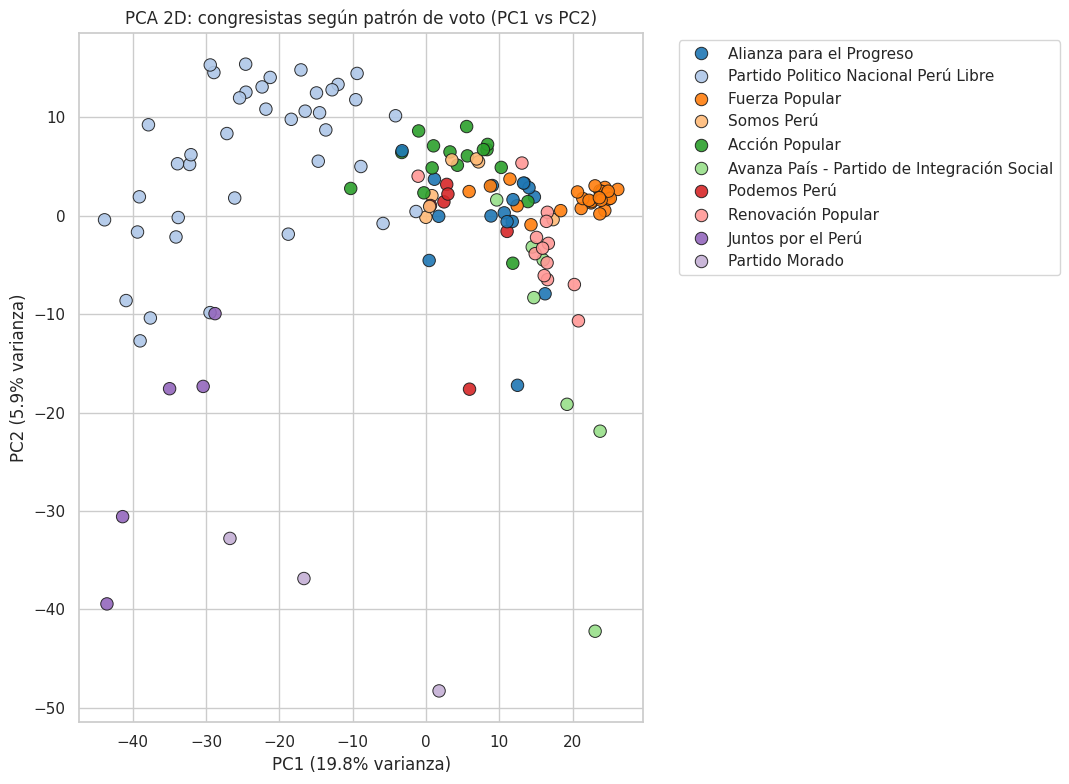

,PC1,PC2,PC3,Congresista,Grupo,Bancada
0,14.793106,1.899127,3.870645,Acuña Peralta María Grimaneza,Alianza para el Progreso,ALIANZA PARA EL PROGRESO
1,0.439040,-4.552512,2.046857,Acuña Peralta Segundo Héctor,Alianza para el Progreso,HONOR Y DEMOCRACIA
2,-28.922049,14.540845,-13.187723,Agüero Gutiérrez María Antonieta,Partido Politico Nacional Perú Libre,PERÚ LIBRE
3,22.526352,1.298361,6.119220,Aguinaga Recuenco Alejandro Aurelio,Fuerza Popular,FUERZA POPULAR
4,0.817632,2.032753,2.650883,Alcarraz Aguero Yorel Kira,Somos Perú,PODEMOS PERÚ


In [32]:
# PCA 2D/3D: imputación, escalado y proyección
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Datos de entrada: filas = congresistas, columnas = votaciones
X_raw = votes.copy()   # usa el DataFrame votes que ya cargaste antes
# Selección de columnas de votación por si hay columnas de metadata incluidas
meta_cols = [c for c in ["Grupo","Bancada","Región","Congresista"] if c in X_raw.columns]
X = X_raw.drop(columns=meta_cols, errors='ignore')

# Imputación y escalado (imputamos por la media de cada columna)
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
pca = PCA(n_components=3, random_state=42)  # pedimos 3 para 2D y 3D

pipeline = make_pipeline(imputer, scaler, pca)
X_pca = pipeline.fit_transform(X.values)

# Guardar proyecciones en DataFrame
pca_df = pd.DataFrame(X_pca, index=X.index, columns=["PC1","PC2","PC3"])
pca_df = pca_df.join(congress[["Congresista","Grupo","Bancada"]])  # nombre y meta

# Varianza explicada
explained = pca.explained_variance_ratio_
print(f"Varianza explicada: PC1={explained[0]:.3f}, PC2={explained[1]:.3f}, PC3={explained[2]:.3f}")
print(f"Total 2 componentes: {(explained[0]+explained[1]):.3f}")

# Scatter 2D (PC1 vs PC2) coloreado por Grupo
plt.figure(figsize=(11,8))
palette = sns.color_palette("tab10", n_colors=len(congress["Grupo"].unique()))
group_codes = pd.Categorical(congress["Grupo"]).codes
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"],
                hue=pca_df["Grupo"], palette="tab20", s=80, alpha=0.9, edgecolor="k")

plt.xlabel(f"PC1 ({explained[0]*100:.1f}% varianza)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}% varianza)")
plt.title("PCA 2D: congresistas según patrón de voto (PC1 vs PC2)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")  # leyenda fuera del plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar tabla con primeras filas del pca_df
pca_df.head()

Plotly no está disponible o hubo un error, usando matplotlib 3D como fallback: No module named 'plotly'


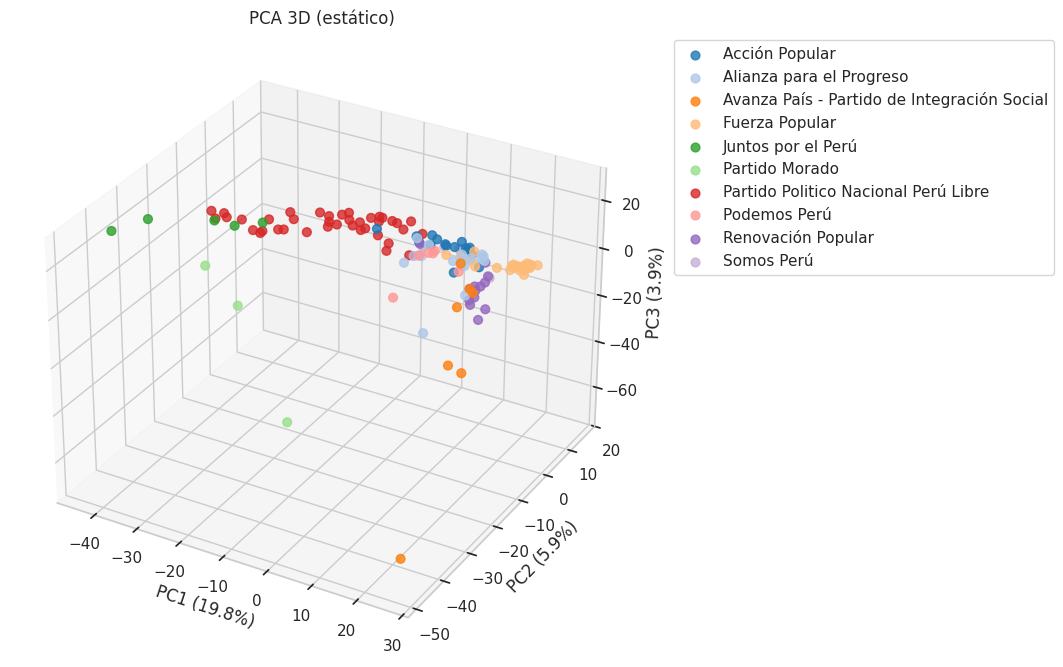

Proyecciones PCA guardadas en pca_proyecciones_congresistas.csv


In [33]:
# PCA 3D interactivo (Plotly) + fallback matplotlib 3D
try:
    import plotly.express as px
    fig3d = px.scatter_3d(
        pca_df,
        x="PC1", y="PC2", z="PC3",
        color="Grupo",
        hover_name="Congresista",
        symbol="Bancada" if "Bancada" in pca_df.columns else None,
        title="PCA 3D: congresistas según patrón de voto (interactivo)",
        labels={
            "PC1": f"PC1 ({explained[0]*100:.1f}%)",
            "PC2": f"PC2 ({explained[1]*100:.1f}%)",
            "PC3": f"PC3 ({explained[2]*100:.1f}%)"
        },
        width=900, height=700
    )
    fig3d.update_traces(marker=dict(size=4))
    fig3d.show()
except Exception as e:
    print("Plotly no está disponible o hubo un error, usando matplotlib 3D como fallback:", e)
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    groups = pca_df["Grupo"].astype('category')
    cmap = plt.get_cmap("tab20")
    for gi, gname in enumerate(groups.cat.categories):
        subset = pca_df[pca_df["Grupo"] == gname]
        ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], label=gname,
                   color=cmap(gi), s=40, alpha=0.8)
    ax.set_xlabel(f"PC1 ({explained[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({explained[1]*100:.1f}%)")
    ax.set_zlabel(f"PC3 ({explained[2]*100:.1f}%)")
    ax.set_title("PCA 3D (estático)")
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Opcional: guardar proyecciones
pca_df.to_csv("pca_proyecciones_congresistas.csv")
print("Proyecciones PCA guardadas en pca_proyecciones_congresistas.csv")

In [34]:
# Clasificación simple para ver cuanto "informa" el patrón de votos sobre la bancada
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# X: congresistas x votaciones
X = votes.fillna(0).values
y = congress["Grupo"].values

rf = RandomForestClassifier(n_estimators=200, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
print("Accuracy CV (RandomForest) promedio:", scores.mean(), "std:", scores.std())

# Entrenar en todo el set para obtener importancias
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=votes.columns).sort_values(ascending=False)
display(importances.head(10))

/home/andre_1/Data-Analysis-Portafolio/Analisis de votaciones en el Congreso de Perú/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Accuracy CV (RandomForest) promedio: 0.8047619047619048 std: 0.07981617832872778


VOTACIÓN DE LA MOCIÓN 501                                                                                                                                             0.009591
VOTACIÓN DE LA ADMISIÓN DE LA  MOCIÓN 1005                                                                                                                            0.007934
VOTACIÓN DE LA ADMISIÓN DE LA  MOCIÓN  DE INTERPELACIÓN 323                                                                                                           0.007628
VOTACIÓN DE LA EXONERACIÓN DE  SEGUNDA VOTACIÓN DEL TEXTO SUSTITUTORIO DEL  PROYECTO 191 Y OTROS                                                                      0.006677
VOTACIÓN DE LA CUESTIÓN PREVIA  PARA QUE SE VOTE POR SEPARADO LA MODIFICACIÓN DEL  ARTÍCULO 58                                                                        0.006164
VOTACIÓN DE LA PROPUESTA DE  LA  MESA DIRECTVA DE SUSPENSI ÓN EN EL EJERCICIO DEL CARGO  Y DESCUENTO DE SUS HABERES POR UN P

Interpretaciones:
- El Congreso, en general, suele tener sus patrones partidarios claros. Es fácil distinguir los votos de las bancadas.
- La bancada más disciplinada es la de Fuerza Popular, por una muy grande diferencia.

In [35]:
# Matriz de acuerdo entre congresistas: proporción de votos iguales (ignorando ausencias)
n = votes.shape[0]
agreement = pd.DataFrame(index=votes.index, columns=votes.index, dtype=float)

for i in votes.index:
    for j in votes.index:
        vi = votes.loc[i]
        vj = votes.loc[j]
        valid = vi.notna() & vj.notna()
        if valid.sum() == 0:
            agreement.loc[i,j] = 0.0
        else:
            agreement.loc[i,j] = (vi[valid] == vj[valid]).mean()

# Construir grafo con umbral (p. ej. acuerdos > 0.75)
threshold = 0.75
G = nx.Graph()
for node in votes.index:
    G.add_node(node, name=congress.loc[node, "Congresista"], group=congress.loc[node, "Grupo"])
for i in agreement.index:
    for j in agreement.columns:
        if i < j and agreement.loc[i,j] >= threshold:
            G.add_edge(i, j, weight=agreement.loc[i,j])

print("Número nodos:", G.number_of_nodes(), "Número aristas (umbral):", G.number_of_edges())

# Opcional: exportar para visualización en Gephi / networkx
nx.write_gexf(G, "co_voto_graph.gexf")

Número nodos: 138 Número aristas (umbral): 6209


Próximos pasos:
- Inspeccionar las votaciones con mayor importancia del clasificador para entender temas polarizadores.
- Investigar congresistas outliers (baja afinidad con su grupo).
- Mejorar imputación de ausencias (modo por bancada o por votación) y ver cuánto cambia PCA/clustering.
- Implementar análisis temporal (si las votaciones tienen fecha) para ver evolución de disciplina.
- Documentar los mapeos manuales de nombres (name_to_id) en un archivo JSON para mantener trazabilidad.

In [36]:
# Guardar métricas
cohesion_df.to_csv("cohesion_por_grupo.csv")
importances.head(50).to_csv("importancias_votaciones.csv")
agreement.to_csv("matriz_acuerdo.csv")
print("Archivos guardados: cohesion_por_grupo.csv, importancias_votaciones.csv, matriz_acuerdo.csv")

Archivos guardados: cohesion_por_grupo.csv, importancias_votaciones.csv, matriz_acuerdo.csv
